In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append(os.path.abspath("../lib"))


In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_dpe_old.csv", "name": "dpe_old", "delimiter": ","},
    {"location": "../training/pred_dpe.csv", "name": "dpe", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
dpe = dataframes['dpe']
old_dpe = dataframes['dpe_old']
dpe_training = old_dpe.drop('GES_emission')
ges_training = old_dpe.drop('DPE_consumption')

dpe_training_cat = dpe_training.withColumn(
    'DPE_consumption',
    F.when(F.col('DPE_consumption') <= 50, 0)
    .when((F.col('DPE_consumption') > 50) & (F.col('DPE_consumption') <= 90), 1)
    .when((F.col('DPE_consumption') > 90) & (F.col('DPE_consumption') <= 150), 2)
    .when((F.col('DPE_consumption') > 150) & (F.col('DPE_consumption') <= 230), 3)
    .when((F.col('DPE_consumption') > 230) & (F.col('DPE_consumption') <= 330), 4)
    .when((F.col('DPE_consumption') > 330) & (F.col('DPE_consumption') <= 450), 5)
    .otherwise(6)
)

ges_training_cat = ges_training.withColumn(
    'GES_emission',
    F.when(F.col('GES_emission') <= 5, 0)
    .when((F.col('GES_emission') > 5) & (F.col('GES_emission') <= 10), 1)
    .when((F.col('GES_emission') > 10) & (F.col('GES_emission') <= 20), 2)
    .when((F.col('GES_emission') > 20) & (F.col('GES_emission') <= 35), 3)
    .when((F.col('GES_emission') > 35) & (F.col('GES_emission') <= 55), 4)
    .when((F.col('GES_emission') > 55) & (F.col('GES_emission') <= 80), 5)
    .otherwise(6)
)

dictionary = dataframes['dictionary']

In [5]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# quickXGboost
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

#hyperparams
from scipy.stats import uniform, randint

In [15]:
from sklearn.model_selection import cross_val_predict
from show import show_matrix, show_result
from sklearn.metrics import f1_score, accuracy_score

In [7]:
categorical_features = [i for i in range(5)]

dpe_param_reg = {'l2_regularization': 0.9632366534401319, 'learning_rate': 0.039390694124254874, 'max_iter': 120, 'categorical_features' : categorical_features}
ges_param_reg = {'l2_regularization': 0.11976213181925122, 'learning_rate': 0.2971581842219685, 'max_iter': 124,'categorical_features' : categorical_features}

ges_param_cat = {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 103}
dpe_param_cat = {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 141}

col_X_hot = []
col_y_ges = ['GES_emission']
col_y_dpe = ['DPE_consumption']

col_X_not_hot = [col[0] for col in ges_training.dtypes if col[0] not in col_X_hot + col_y_ges]

X_dpe = dpe_training.select(col_X_not_hot).toPandas().to_numpy()
X_ges = ges_training.select(col_X_not_hot).toPandas().to_numpy()

y_ges_cat = ges_training_cat.select(col_y_ges).toPandas().to_numpy().ravel()
y_dpe_cat = dpe_training_cat.select(col_y_dpe).toPandas().to_numpy().ravel()
if 0 not in np.unique(y_ges_cat):
    y_ges_cat = y_ges_cat - 1
if 0 not in np.unique(y_dpe_cat):
    y_dpe_cat = y_dpe_cat - 1

y_ges_reg = ges_training.select(col_y_ges).toPandas().to_numpy().ravel()
y_dpe_reg = dpe_training.select(col_y_dpe).toPandas().to_numpy().ravel()

treshold = 100000
if X_dpe.shape[0] > treshold:
    np.random.seed(42)
    indexes = np.random.choice(X_dpe.shape[0], treshold, replace=False)
    X_dpe = X_dpe[indexes, :]
    X_ges = X_ges[indexes, :]
    y_ges_cat = y_ges_cat[indexes]
    y_dpe_cat = y_dpe_cat[indexes]
    y_ges_reg = y_ges_reg[indexes]
    y_dpe_reg = y_dpe_reg[indexes]


In [8]:
ges_regressor = HistGradientBoostingRegressor(**ges_param_reg)
dpe_regressor = HistGradientBoostingRegressor(**dpe_param_reg)
ges_classifier = RandomForestClassifier(**ges_param_cat)
dpe_classifier = RandomForestClassifier(**dpe_param_cat)

y_pred_ges_regressor = cross_val_predict(ges_regressor, X_ges, y_ges_reg, cv=4)
y_pred_dpe_regressor = cross_val_predict(dpe_regressor, X_dpe, y_dpe_reg, cv=4)
y_pred_ges_classifier = cross_val_predict(ges_classifier, X_ges, y_ges_cat, cv=4)
y_pred_dpe_classifier = cross_val_predict(dpe_classifier, X_dpe, y_dpe_cat, cv=4)

In [9]:
y_pred_ges_regressor_to_cat = (
    spark.createDataFrame(y_pred_ges_regressor, ['GES_emission'])
    .withColumn(
        'GES_emission',
        F.when(F.col('GES_emission') <= 5, 0)
        .when((F.col('GES_emission') > 5) & (F.col('GES_emission') <= 10), 1)
        .when((F.col('GES_emission') > 10) & (F.col('GES_emission') <= 20), 2)
        .when((F.col('GES_emission') > 20) & (F.col('GES_emission') <= 35), 3)
        .when((F.col('GES_emission') > 35) & (F.col('GES_emission') <= 55), 4)
        .when((F.col('GES_emission') > 55) & (F.col('GES_emission') <= 80), 5)
        .otherwise(6)
    )
    .toPandas()
    .to_numpy()
    .ravel()
)

y_pred_dpe_regressor_to_cat = (
    spark.createDataFrame(y_pred_dpe_regressor, ['DPE_consumption'])
    .withColumn(
        'DPE_consumption',
        F.when(F.col('DPE_consumption') <= 50, 0)
        .when((F.col('DPE_consumption') > 50) & (F.col('DPE_consumption') <= 90), 1)
        .when((F.col('DPE_consumption') > 90) & (F.col('DPE_consumption') <= 150), 2)
        .when((F.col('DPE_consumption') > 150) & (F.col('DPE_consumption') <= 230), 3)
        .when((F.col('DPE_consumption') > 230) & (F.col('DPE_consumption') <= 330), 4)
        .when((F.col('DPE_consumption') > 330) & (F.col('DPE_consumption') <= 450), 5)
        .otherwise(6)
    )
    .toPandas()
    .to_numpy()
    .ravel()
)

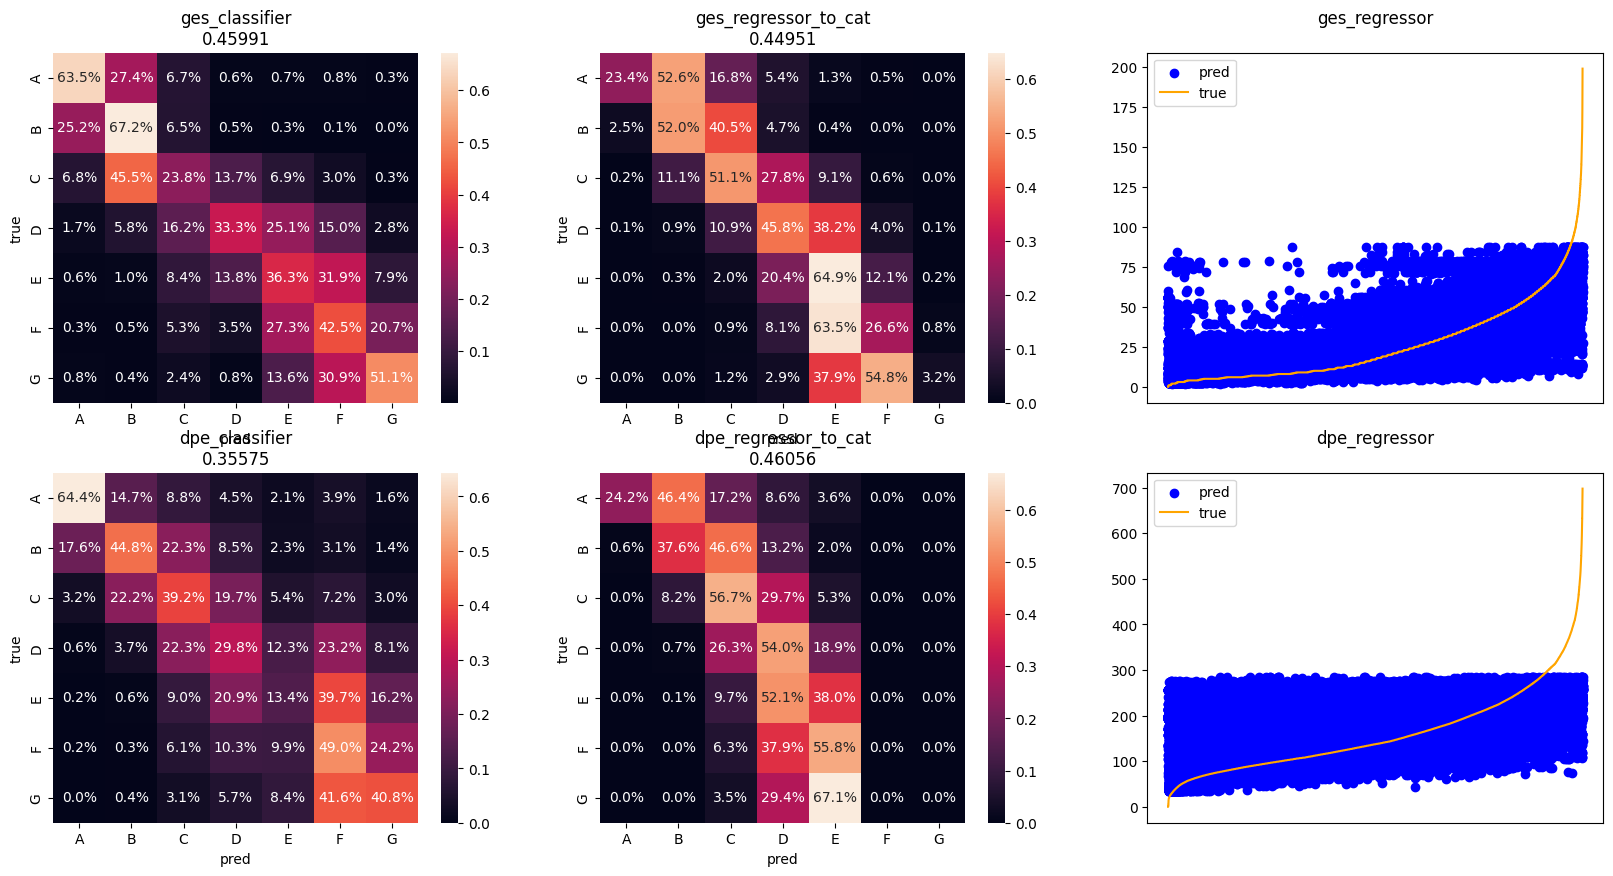

In [17]:
f, ax = plt.subplots(2,3, figsize=(20,10))
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
show_matrix(y_pred_ges_classifier, y_ges_cat, ax[0,0], f'ges_classifier\n{accuracy_score(y_ges_cat, y_pred_ges_classifier)}', labels)
show_matrix(y_pred_ges_regressor_to_cat, y_ges_cat, ax[0,1], f'ges_regressor_to_cat\n{accuracy_score(y_ges_cat, y_pred_ges_regressor_to_cat)}', labels)
show_result(y_pred_ges_regressor, y_ges_reg, ax[0,2], f'ges_regressor\n')

show_matrix(y_pred_dpe_classifier, y_dpe_cat, ax[1,0], f'dpe_classifier\n{accuracy_score(y_dpe_cat, y_pred_dpe_classifier)}', labels)
show_matrix(y_pred_dpe_regressor_to_cat, y_dpe_cat, ax[1,1], f'dpe_regressor_to_cat\n{accuracy_score(y_dpe_cat, y_pred_dpe_regressor_to_cat)}', labels)
show_result(y_pred_dpe_regressor, y_dpe_reg, ax[1,2], f'dpe_regressor\n')
plt.show()